In [1]:
%matplotlib inline

In [2]:
# 导入相关库
import numpy as np # 数据处理库
from scipy import ndimage # 数据处理库
import pandas as pd
import os
import skimage.io as io # 用于读写图像
from skimage.transform import rescale # 用于标定图像的宽和高
from skimage import img_as_ubyte # 标定图像格式
from skimage.measure import label, regionprops # 用于连通域分析
from skimage.filters import threshold_otsu, threshold_local # 用于阈值分割
# 形态学处理相关库
from skimage.morphology import skeletonize # 用提取于二维骨架
from skimage.morphology import erosion, dilation, opening, closing, remove_small_holes
from skimage.morphology import disk
from skimage import feature, filters
from skimage import morphology, measure
from skimage import draw
from scipy.spatial import distance
from skimage import util 

from skimage import color
from skimage.filters import unsharp_mask
from skimage import exposure
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt 

In [3]:
# 函数1：动态转换图像的原始分辨率
def img_rescale(image):
    """Resize the height of image to 1024 pixels."""
    Resize_Ratio = 1.0/(image.shape[0]/1024.0) 
    # 将图像的y轴长度转换为1024
    img_resized = img_as_ubyte(rescale(image.copy(), 
                                         Resize_Ratio,multichannel=True))
    return img_resized

In [4]:
# 函数2：检测感兴趣区域（ROI）
def find_roi(image, obj_ratio, convex_ratio, 
             width_ratio, intensity_img, dilate = True):
    '''Find the region of interest'''
    label, num = ndimage.measurements.label(image)
    obj_size = image.sum() * obj_ratio
    Blank_Img = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    Final_ROI_img = Blank_Img.copy()

    for prop in regionprops(label, intensity_image=intensity_img, cache=False):
        if prop.area < obj_size:
            continue
        if prop.convex_area < (convex_ratio * obj_size / obj_ratio):
            continue
        if prop.minor_axis_length < image.shape[1] * width_ratio:
            continue
        
        ROI_tmp_img = Blank_Img.copy()
        ROI_coord = prop.coords.astype(int)
 
        # 被标记区域的坐标
        ROI_tmp_img[ROI_coord[:,0], ROI_coord[:,1]] = 1
        Final_ROI_img = np.logical_or(ROI_tmp_img, Final_ROI_img)
    
    if dilate:
        Skl_img = dilation(skeletonize(Final_ROI_img), disk(1))
    else:
        Skl_img = skeletonize(Final_ROI_img)

    return Final_ROI_img, Skl_img

In [5]:
# 函数3：去除误检测的对象
def remov_mis_obj(Kernal_Final, intensity_image, show_result=False):
    """Remove uninterest objects in spike image."""
    Labelled_spike_Img, num_features = ndimage.measurements.label(Kernal_Final) 
    Blank_Img = np.zeros(Kernal_Final.shape, dtype=np.uint8)
    Final_spike_img = Blank_Img.copy()
    kernal_counter = 1
    
    if show_result:
        fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(30, 30))
    
    for obj_id in regionprops(Labelled_spike_Img, intensity_image, cache=True):
        if obj_id.area < 75:
            continue
        # 枝梗颜色一般偏绿:
        if obj_id.mean_intensity < 75:
            continue
        # 枝梗对象的形状偏狭长:
        if obj_id.major_axis_length / (obj_id.minor_axis_length + 1) > 30:
            continue
        ROI_tmp_img = Blank_Img.copy()
        ROI_coord = obj_id.coords.astype(int)
        # 提取符合条件的蒙版：
        ROI_tmp_img[ROI_coord[:,0], ROI_coord[:,1]] = 1
        Final_spike_img = np.logical_or(ROI_tmp_img, Final_spike_img)
        
        if show_result:
            print("ID",kernal_counter, "area: ", obj_id.area)
            print("L: ", obj_id.major_axis_length, "W: ", obj_id.minor_axis_length)
            print("mean intensity: ", obj_id.mean_intensity)
           
            ax1.text(obj_id.bbox[1]-10, obj_id.bbox[0], '%d' %(kernal_counter), ha='center', 
                        va='center', color = 'cyan', fontweight='bold', size = 16) 
        kernal_counter = kernal_counter + 1
    if show_result:
        ax1.imshow(Final_spike_img, cmap='gray')
        ax1.set_title('Final_spike_img', fontsize=20)
        
    return Final_spike_img

In [6]:
# 函数4：提取二维骨架的端点和分支结点
from scipy.ndimage import binary_hit_or_miss

def find_end_points(skel):
    """Detect end points of a skeleton"""
    # Four possible matrix representation
    struct1, origin1 = np.array([
            [0, 0, 0],
            [0, 1, 0],
        ]), (0, 0)
    struct2, origin2 = np.array([
            [0, 0],
            [0, 1],
            [0, 0],
        ]), (0, 0)
    struct3, origin3 = np.array([
            [0, 1, 0],
            [0, 0, 0],
        ]), (-1, 0)
    struct4, origin4 = np.array([
            [0, 0],
            [1, 0],
            [0, 0],
        ]), (0, -1)
    
    # Match end point structures with the skeleton
    ret = None
    for i in range(1, 5):
        struct, origin = locals()['struct%d' % (i)], locals()['origin%d' % (i)]
        if ret is None:
            ret = binary_hit_or_miss(skel, structure1=struct, origin1=origin)
        else:
            ret = np.logical_or(ret, binary_hit_or_miss(skel, structure1=struct, origin1=origin))
    return np.transpose(np.nonzero(ret)[::-1])

def find_branches(skel):
    """Detect branching points of a skeleton"""
    # Five possible matrix representation
    struct1 = np.array([
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 1]
    ])   
    struct2 = np.array([
        [1, 0, 0],
        [0, 1, 1],
        [0, 1, 0]
    ])
    struct3 = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 1]
    ])    
    struct4 = np.array([
        [0, 0, 0],
        [1, 1, 1],
        [0, 1, 0]
    ])
    struct5 = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ])
    
    # Match branching point structures with the skeleton
    structs = [np.rot90(struct1, i)   for i in range(4)]
    structs += [np.rot90(struct2, i)   for i in range(4)]
    structs += [np.rot90(struct3, i)   for i in range(4)]
    structs += [np.rot90(struct4, i)   for i in range(4)]
    structs += [np.rot90(struct5, i)   for i in range(4)]
    
    ret = None
    for i in range(len(structs)):
        if ret is None:
            ret = binary_hit_or_miss(skel, structure1=structs[i])
        else:
            ret = np.logical_xor(ret, binary_hit_or_miss(skel, structure1=structs[i]))
    return np.transpose(np.nonzero(ret)[::-1])

In [7]:
# 函数5：使用BFS广度优先搜索法，提取指定两个端点间的骨架
from collections import deque
import sys

def bfs_search(curve, branch_point, end_point):
    curve = skeleton
    height, width = len(curve), len(curve[0])
    # 需要提取的骨架的端点坐标
    start, end = (end_point[1], end_point[0]), (branch_point[1], branch_point[0])
    delta = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]

    grid = [[sys.maxsize for _ in range(width)] for _ in range(height)]
    grid[start[0]][start[1]] = 0

    # 开始执行BFS算法
    bfs = deque([start])
    found = False
    while len(bfs) > 0:
        y, x = bfs.popleft()
        # 到达终点
        if (y, x) == end:
            found = True
            break

        for dy, dx in delta:
            yy, xx = y + dy, x + dx
            if 0 <= yy < height and 0 <= xx < width and grid[y][x] + 1 < grid[yy][xx] and curve[yy][xx] != 0:
                grid[yy][xx] = grid[y][x] + 1
                bfs.append((yy, xx))

    if found:
        path = []
        y, x = end
        while grid[y][x] != 0:
            for dy, dx in delta:
                yy, xx = y + dy, x + dx
                if 0 <= yy < height and 0 <= xx < width and grid[yy][xx] == grid[y][x] - 1:
                    path.append((yy, xx))
                    y, x = yy, xx
        path.pop()

    else:
        print(f'No path found between {start} and {end}')

    # 将提取出的主干枝梗坐标点转化为图像
    shoot_ske_1 = Blank_Img.copy()
    for r,c in path:
        shoot_ske_1[r,c] = 1
        
    return shoot_ske_1

In [8]:
img_path = r'./Data/images/室内采集图像.JPG'
# img_path = r'./Data/images/手机采集图像.JPG'
reference_img_path = r'./Data/images/基准图像.JPG'

In [9]:
# 图像读取
image = io.imread(img_path)
reference = img_rescale(io.imread(reference_img_path))
# 图像校准与增强
image_resized = img_rescale(image)
matched = match_histograms(image_resized, reference, multichannel=True)
kernal_img = matched[:,:,0]
region_img = unsharp_mask(matched, radius=10, amount=2) # 反锐化遮罩增强图像
skeleton_img = color.rgb2lab(matched) # lab色彩空间图像

In [10]:
# 提取ROI
# ROI_img = skeleton_img[:,:,0] - skeleton_img[:,:,1]
ROI_img = region_img[:,:,0]
global_thresh = threshold_otsu(ROI_img)
block_size = 15
binary_adaptive = threshold_local(ROI_img, block_size, offset=5)

ROI_outline = binary_adaptive - ROI_img
ROI_outline_Value = threshold_otsu(ROI_outline)

selem = disk(5)
ROI_Ref = dilation(ROI_img > global_thresh, selem)
ROI_outline_1 = ROI_outline < ROI_outline_Value
Final_ROI_img, Skl_Img_Ref = find_roi(ROI_Ref, 0.01, 0.1, 0.2, ROI_img)

Text(0.5, 1.0, 'ROI_outline_1')

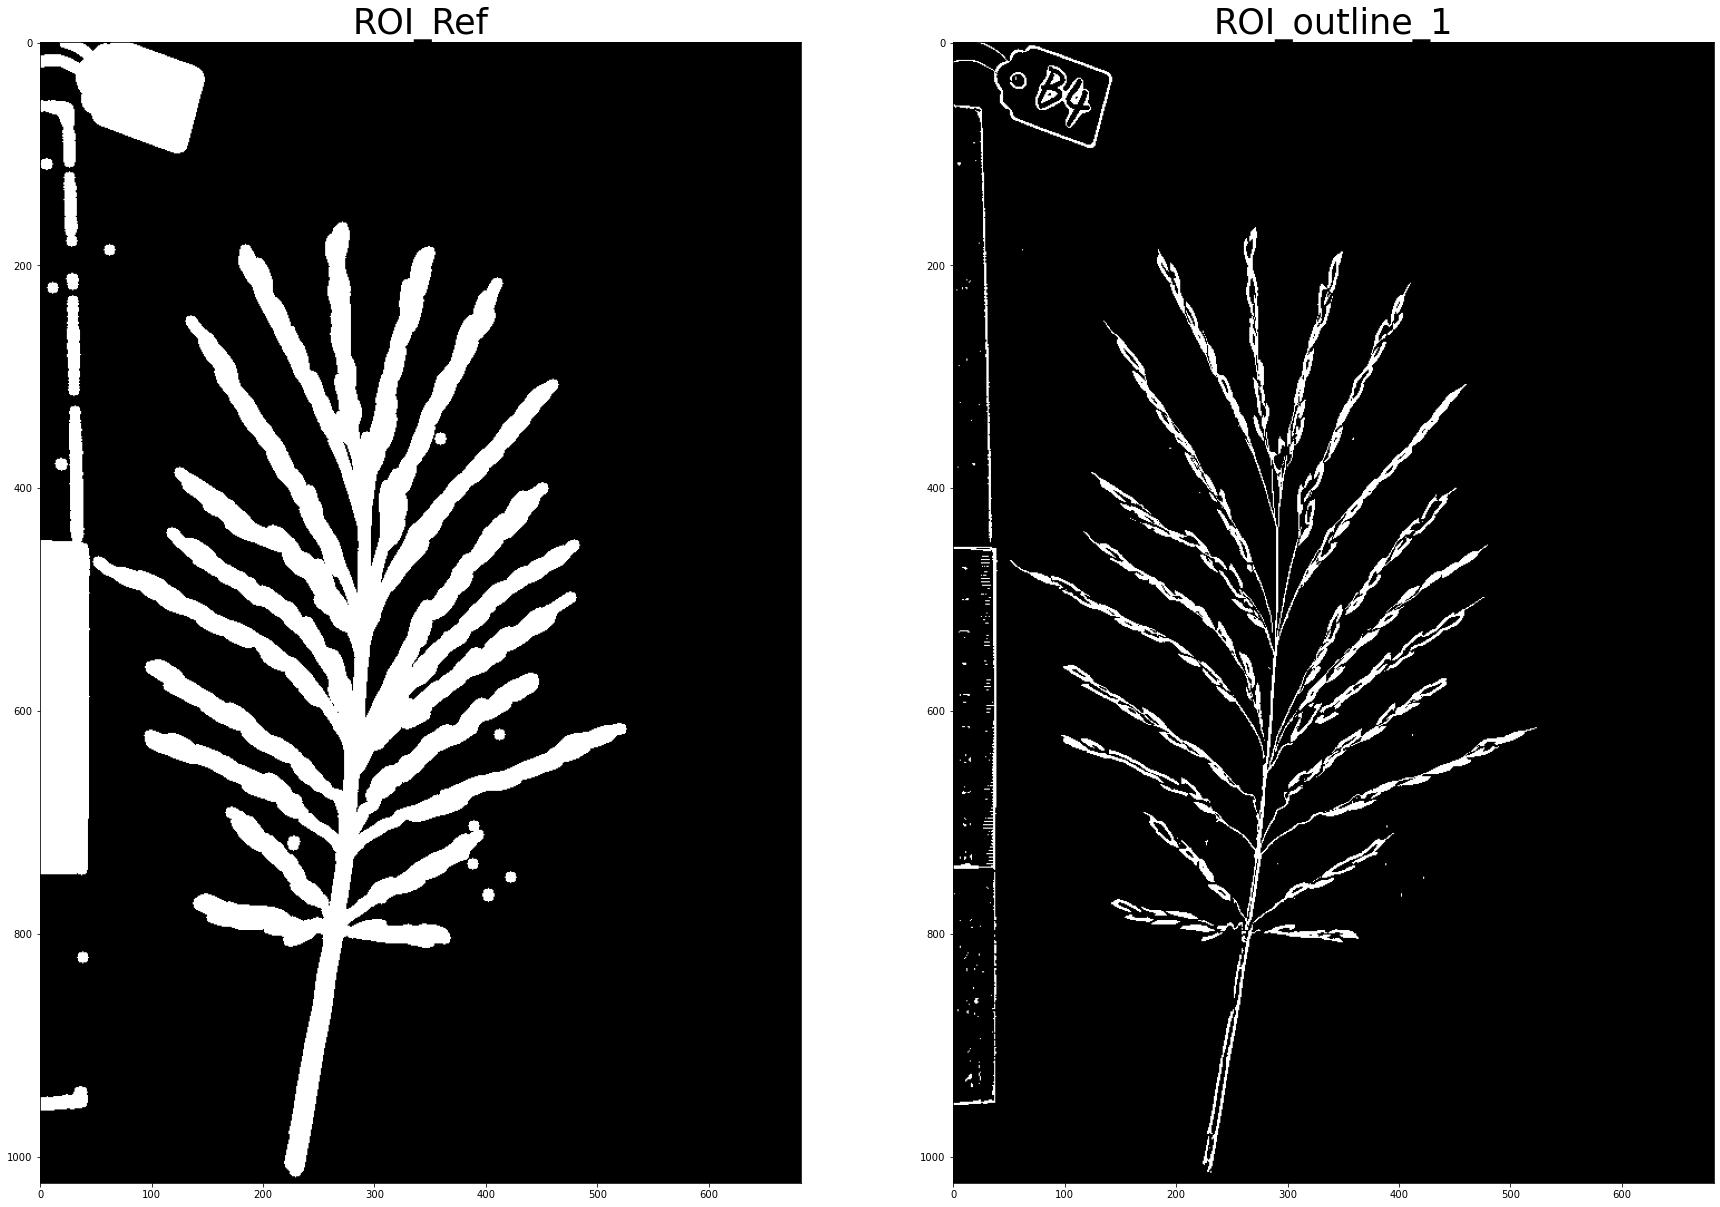

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(30, 30))
ax1.imshow(ROI_Ref, cmap='gray')
ax1.set_title('ROI_Ref', fontsize=35)
ax2.imshow(ROI_outline_1, cmap='gray')
ax2.set_title('ROI_outline_1', fontsize=35)

In [12]:
# 分析标签的像素宽度
marker_img = remove_small_holes(region_img[:,:,0]>0.99, area_threshold = 6000)
marker_img = np.logical_and(np.invert(Final_ROI_img), marker_img)
table = measure.regionprops_table(label(img_as_ubyte(marker_img)), properties=('label', 'area'))
l_label = table['label'][table['area'].argmax()]
marker_mask = label(img_as_ubyte(marker_img)) == l_label
marker_mask = morphology.closing(marker_mask, selem=disk(10))
pixel_width = np.round(ndimage.distance_transform_edt(marker_mask).max() *2 ) * image.shape[0] / 1024
pm_ratio = 26 / pixel_width

In [13]:
# 检测稻穗区域
elevation_map = filters.sobel(region_img[:,:,0])
elevation_map_ref = elevation_map > (elevation_map.max() - elevation_map.mean())*0.5 

# 去除直尺对象
ROI_Outline = np.logical_and(Final_ROI_img, elevation_map_ref)

img_red = image_resized[:,:,0]
block_size = 25
img_red_ref = threshold_local(img_red, block_size, offset=10)
Kernal_ROI = np.logical_and(img_red > img_red_ref, Final_ROI_img)

# 二维骨架分析
skeleton = skeletonize(morphology.remove_small_objects(Final_ROI_img, 25))
# skeleton = medial_axis(morphology.remove_small_objects(Final_ROI_img, 25))
ske_end = find_end_points(skeleton)
end_point_1 = ske_end[-1]
ske_branch = find_branches(skeleton)
branch_point_1 = ske_branch[-1]

# 找出最靠近底部的分支点，并避开过短的分支
Blank_Img = np.zeros(skeleton.shape)
tmp = Blank_Img.copy()
small_branch = Blank_Img.copy()
# small_branch = skeleton.copy()
for end_point in ske_end:
    rr, cc = draw.disk((end_point[1], end_point[0]), radius=12, shape=skeleton.shape)
    tmp[rr,cc] = 1
    small_branch = np.logical_or(small_branch, tmp)

remov_smal_ske = np.logical_and(skeleton, np.logical_not(small_branch))

ske_branch = find_branches(remov_smal_ske)
branch_point_2 = ske_branch[-1]

end_stem = dilation(bfs_search(skeleton, branch_point_2, end_point_1), disk(12))>0

# 分离穗轴和枝梗
Kernal_Sep = np.logical_xor(ROI_Outline, Kernal_ROI) 
Kernal_Sep_Ref = morphology.remove_small_objects(Kernal_Sep, 25)
Kernal_Sep_Fin = dilation(Kernal_Sep_Ref, disk(1))
Kernal_Final = morphology.remove_small_objects(np.logical_and(Kernal_ROI, Kernal_Sep_Fin), 25)

# lab颜色空间分析
lab_scaled = (skeleton_img + [0, 128, 128]) / [100, 255, 255] 
stem_img = lab_scaled[:,:,1] 
inverted_stem_img = util.invert(stem_img)
inverted_stem_img[np.invert(Final_ROI_img)] = 0 
stem_img_Ref = inverted_stem_img > inverted_stem_img.max()*0.95

sep = np.logical_xor(Kernal_Final, stem_img_Ref)
Final_spike_img = remov_mis_obj(sep, image_resized[:,:,0], 
                                    show_result=False)

Final_Spike_ROI = np.logical_and(np.invert(stem_img_Ref), Final_spike_img)
Final_Spike_ROI = np.logical_and(Final_Spike_ROI, np.invert(end_stem))
Final_Spike_ROI_1 = morphology.remove_small_objects(Final_Spike_ROI, 25)

In [14]:
# 将相关变量存储到多维数据集
pandas_list = []
pandas_list.append([image_resized.tolist(), matched.tolist(), Final_Spike_ROI_1.tolist(), pm_ratio])
datacube_dt = pd.DataFrame(pandas_list, columns=['image_resized', 'matched', 'spike_mask', 'pm_ratio'])
datacube_dt.to_csv(r'./Data/datacubes/datacube_1.csv')

In [15]:
datacube_dt

,image_resized,matched,spike_mask,pm_ratio
0,"[[[0, 2, 0], [0, 2, 0], [1, 2, 0], [1, 2, 0], ...","[[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], ...","[[False, False, False, False, False, False, Fa...",0.066032


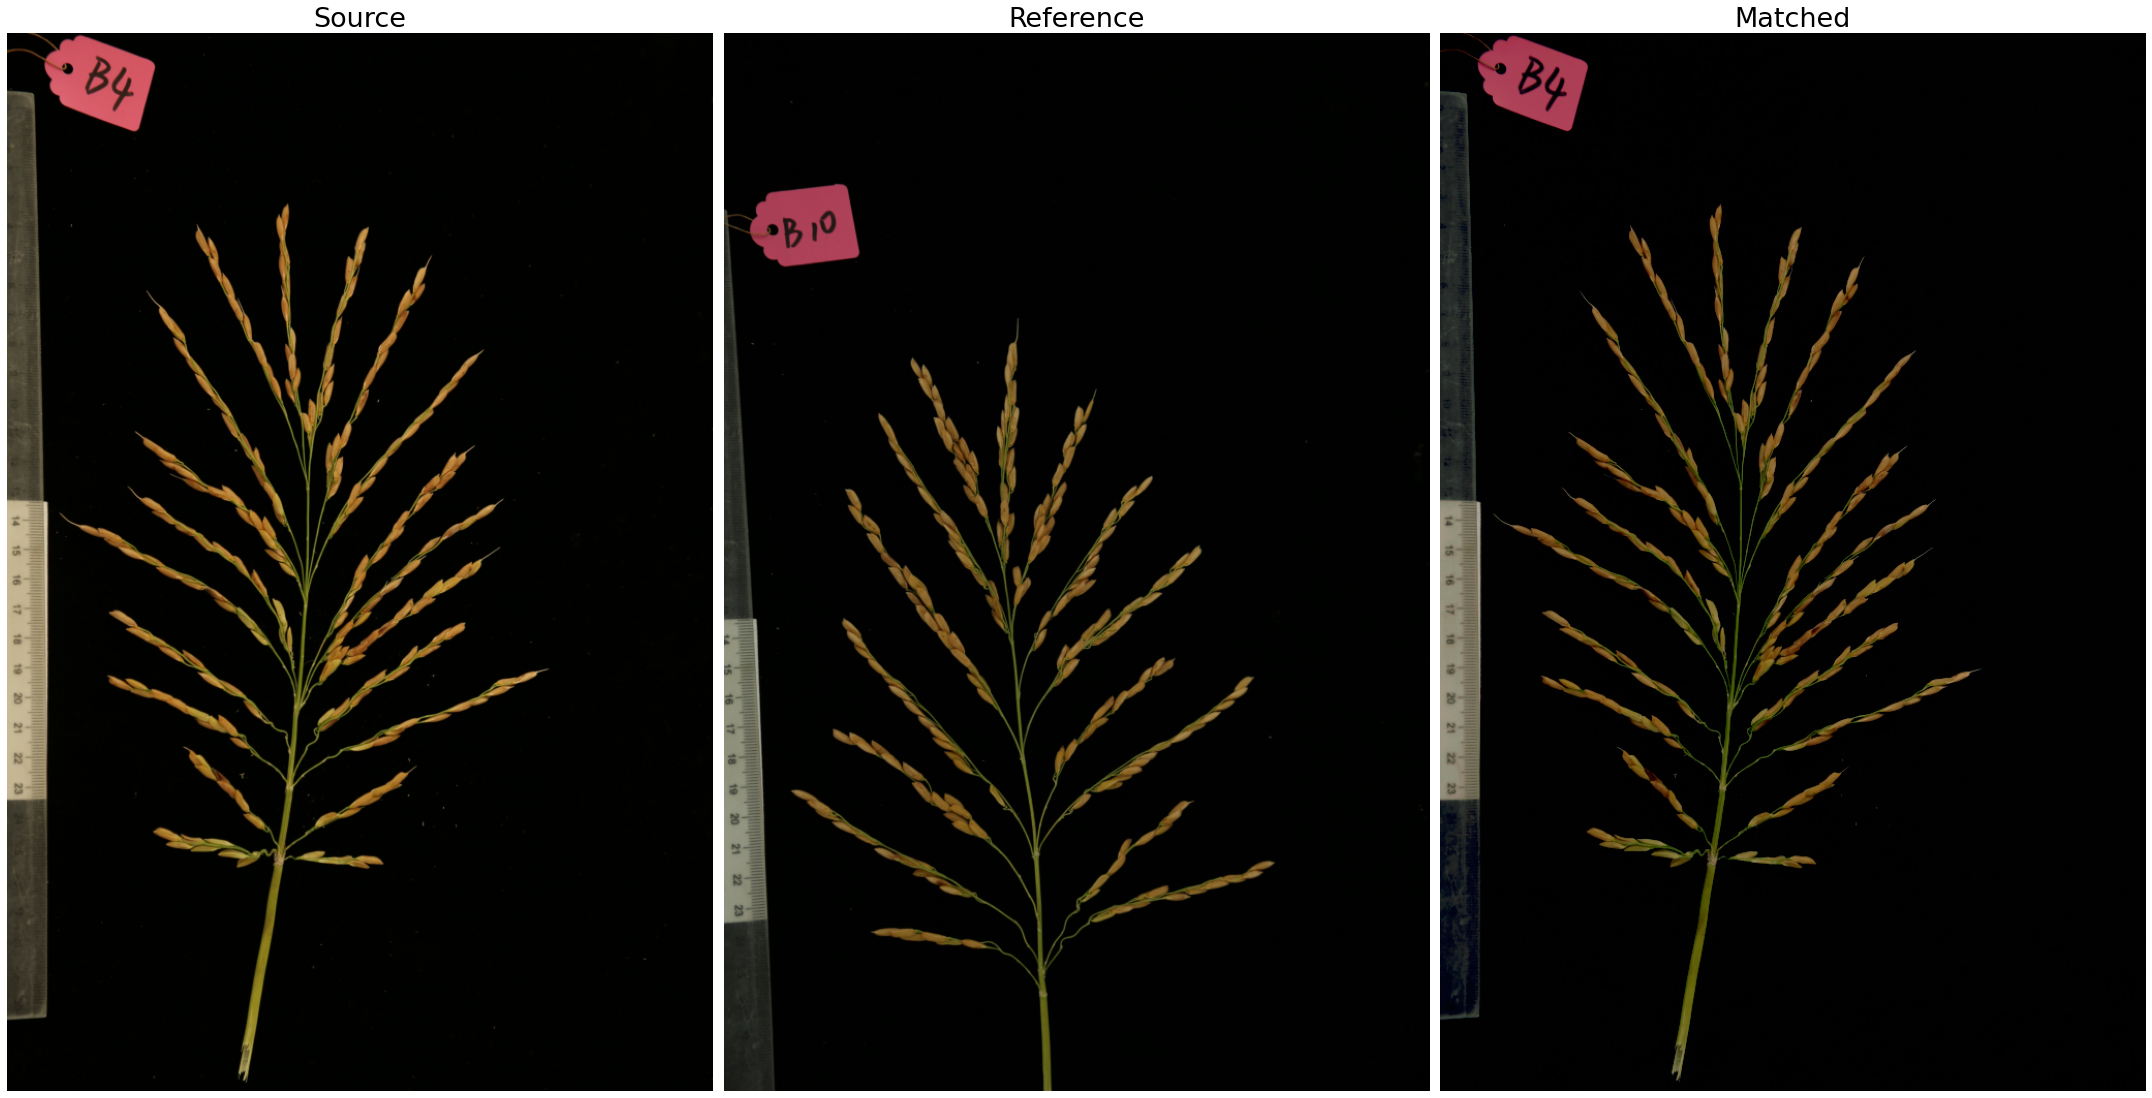

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 20),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image_resized)
ax1.set_title('Source', fontsize=27)
ax2.imshow(reference)
ax2.set_title('Reference', fontsize=27)
ax3.imshow(matched)
ax3.set_title('Matched', fontsize=27)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ROI_outline_1')

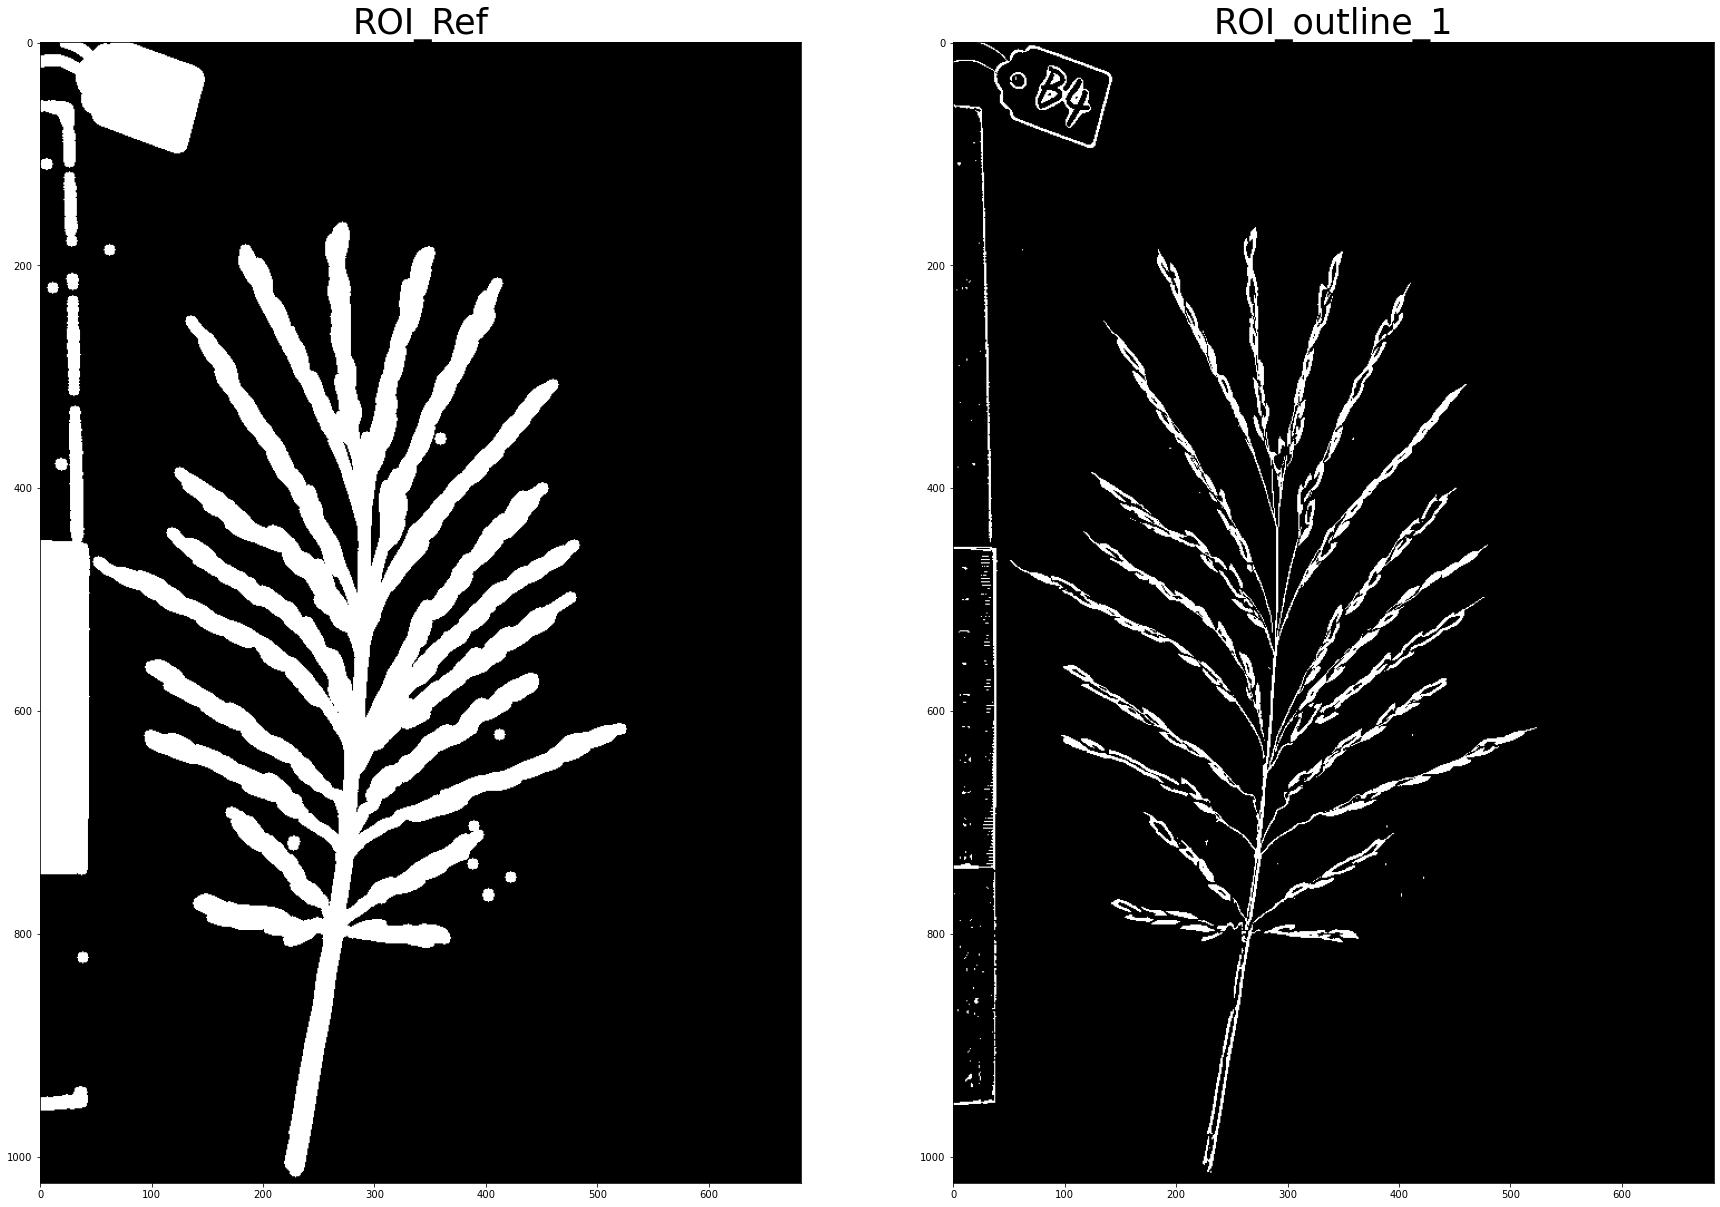

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(30, 30))
ax1.imshow(ROI_Ref, cmap='gray')
ax1.set_title('ROI_Ref', fontsize=35)
ax2.imshow(ROI_outline_1, cmap='gray')
ax2.set_title('ROI_outline_1', fontsize=35)

Text(0.5, 1.0, 'Skl_Img_Ref')

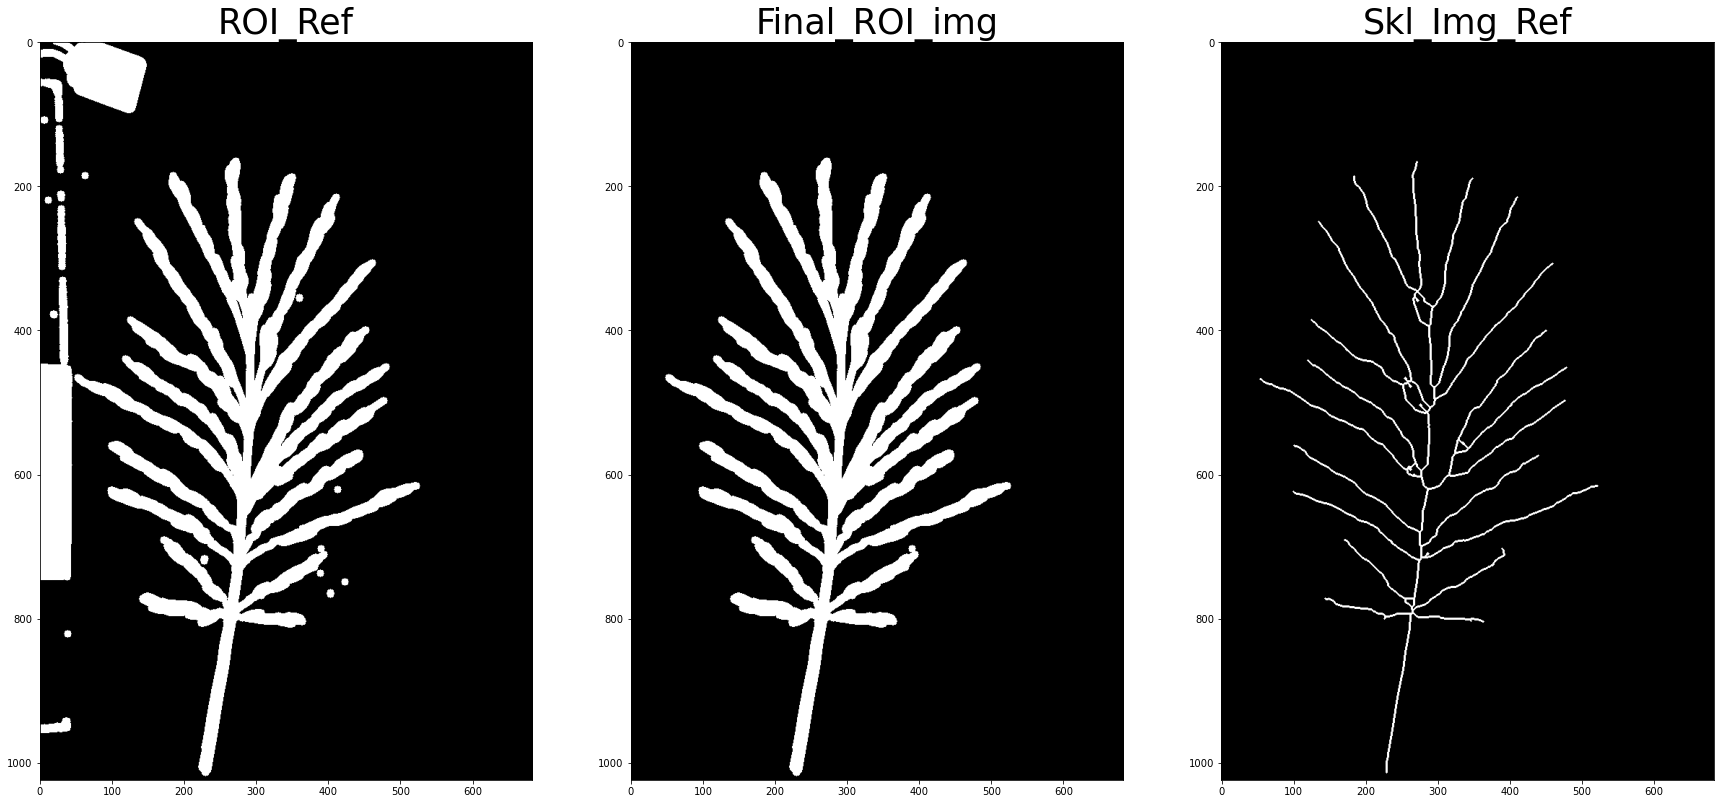

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(30, 30))
ax1.imshow(ROI_Ref, cmap = 'gray')
ax1.set_title('ROI_Ref', fontsize=35)
ax2.imshow(Final_ROI_img, cmap = 'gray')
ax2.set_title('Final_ROI_img', fontsize=35)
ax3.imshow(Skl_Img_Ref, cmap = 'gray')
ax3.set_title('Skl_Img_Ref', fontsize=35)

Text(0.5, 1.0, 'Final_Spike_ROI')

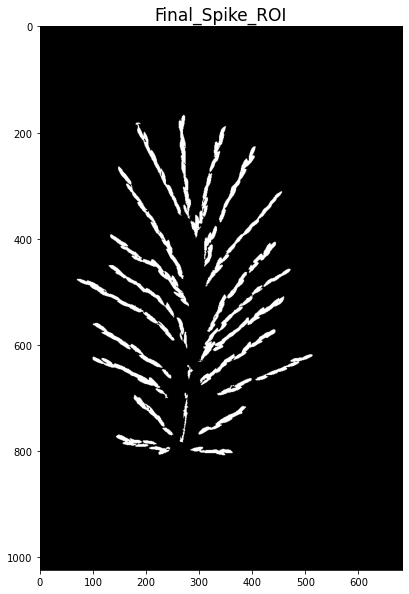

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(Final_Spike_ROI_1, cmap='gray')
plt.title('Final_Spike_ROI', fontsize=17)